In [1]:
import os
os.getcwd()

'C:\\Users\\Administrator\\FTP\\20230715'

In [2]:
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

In [3]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        if use_1x1conv:
            self.conv3 = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=stride
            )
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)


def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(in_channels, out_channels, use_1x1conv=True, stride=2)
            )
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)


class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])



In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.data[index]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.data)

In [5]:
# 修改数据预处理
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [6]:
# 加载FER2013数据集的CSV文件
data = pd.read_csv('fer2013.csv')

# 数据预处理和加载
train_data = []
test_data = []

for i in range(len(data)):
    emotion = data['emotion'][i]
    pixels = data['pixels'][i].split()
    image = Image.new('L', (48, 48))  # 创建灰度图像对象
    image.putdata([int(p) for p in pixels])  # 将像素值填充到图像中

    if data['Usage'][i] == 'Training':
        train_data.append((image, emotion))
    elif data['Usage'][i] == 'PublicTest':
        test_data.append((image, emotion))
    elif data['Usage'][i] == 'PrivateTest':
        test_data.append((image, emotion))

# 创建训练数据集和测试数据集
train_dataset = CustomDataset(train_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

# 创建训练数据集和测试数据集的加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
learning_rate = 0.01
num_epochs = 100
Loss = []
Accuracy = []

In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

model.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
model.add_module("resnet_block2", resnet_block(64, 128, 2))
model.add_module("resnet_block3", resnet_block(128, 256, 2))
model.add_module("resnet_block4", resnet_block(256, 512, 2))
model.add_module("global_avg_pool", GlobalAvgPool2d())
model.add_module("fc", nn.Sequential(Reshape(), nn.Linear(512, 7)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
from tqdm import tqdm
print(train_dataset.__len__())


28709
22


In [10]:

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0.0
    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)
    Loss.append(train_loss)
    Accuracy.append(train_accuracy)
    
    model.eval()
    test_loss = 0.0
    test_correct = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(test_dataset)
    test_accuracy = test_correct / len(test_dataset)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:14<00:00, 60.16it/s]


Epoch [1/100], Train Loss: 1.7972, Train Accuracy: 0.2719, Test Loss: 1.6906, Test Accuracy: 0.3318


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.01it/s]


Epoch [2/100], Train Loss: 1.5952, Train Accuracy: 0.3662, Test Loss: 1.7176, Test Accuracy: 0.3554


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.37it/s]


Epoch [3/100], Train Loss: 1.4675, Train Accuracy: 0.4284, Test Loss: 1.5381, Test Accuracy: 0.4118


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.25it/s]


Epoch [4/100], Train Loss: 1.3575, Train Accuracy: 0.4713, Test Loss: 1.3612, Test Accuracy: 0.4787


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.07it/s]


Epoch [5/100], Train Loss: 1.2857, Train Accuracy: 0.5069, Test Loss: 1.3025, Test Accuracy: 0.4941


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.33it/s]


Epoch [6/100], Train Loss: 1.2261, Train Accuracy: 0.5345, Test Loss: 1.3397, Test Accuracy: 0.4877


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 80.23it/s]


Epoch [7/100], Train Loss: 1.1662, Train Accuracy: 0.5608, Test Loss: 1.3685, Test Accuracy: 0.4950


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.33it/s]


Epoch [8/100], Train Loss: 1.1005, Train Accuracy: 0.5889, Test Loss: 1.2167, Test Accuracy: 0.5357


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.02it/s]


Epoch [9/100], Train Loss: 1.0277, Train Accuracy: 0.6197, Test Loss: 1.2365, Test Accuracy: 0.5362


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.36it/s]


Epoch [10/100], Train Loss: 0.9586, Train Accuracy: 0.6491, Test Loss: 1.2372, Test Accuracy: 0.5475


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.91it/s]


Epoch [11/100], Train Loss: 0.8770, Train Accuracy: 0.6819, Test Loss: 1.3099, Test Accuracy: 0.5518


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.07it/s]


Epoch [12/100], Train Loss: 0.8015, Train Accuracy: 0.7118, Test Loss: 1.3277, Test Accuracy: 0.5410


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.55it/s]


Epoch [13/100], Train Loss: 0.7089, Train Accuracy: 0.7471, Test Loss: 1.3924, Test Accuracy: 0.5490


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.58it/s]


Epoch [14/100], Train Loss: 0.6343, Train Accuracy: 0.7739, Test Loss: 1.4391, Test Accuracy: 0.5460


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.85it/s]


Epoch [15/100], Train Loss: 0.5731, Train Accuracy: 0.7999, Test Loss: 1.4810, Test Accuracy: 0.5563


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.60it/s]


Epoch [16/100], Train Loss: 0.4905, Train Accuracy: 0.8291, Test Loss: 1.6183, Test Accuracy: 0.5442


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.52it/s]


Epoch [17/100], Train Loss: 0.4423, Train Accuracy: 0.8490, Test Loss: 1.6453, Test Accuracy: 0.5482


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.84it/s]


Epoch [18/100], Train Loss: 0.3917, Train Accuracy: 0.8661, Test Loss: 1.8536, Test Accuracy: 0.5467


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.37it/s]


Epoch [19/100], Train Loss: 0.3637, Train Accuracy: 0.8784, Test Loss: 1.8184, Test Accuracy: 0.5520


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.93it/s]


Epoch [20/100], Train Loss: 0.3373, Train Accuracy: 0.8865, Test Loss: 1.9660, Test Accuracy: 0.5543


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.06it/s]


Epoch [21/100], Train Loss: 0.3025, Train Accuracy: 0.8998, Test Loss: 2.0042, Test Accuracy: 0.5266


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:12<00:00, 73.84it/s]


Epoch [22/100], Train Loss: 0.2788, Train Accuracy: 0.9093, Test Loss: 1.9991, Test Accuracy: 0.5549


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:12<00:00, 74.34it/s]


Epoch [23/100], Train Loss: 0.2673, Train Accuracy: 0.9105, Test Loss: 2.0177, Test Accuracy: 0.5461


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 75.14it/s]


Epoch [24/100], Train Loss: 0.2461, Train Accuracy: 0.9210, Test Loss: 2.1937, Test Accuracy: 0.5534


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.00it/s]


Epoch [25/100], Train Loss: 0.2343, Train Accuracy: 0.9233, Test Loss: 2.1887, Test Accuracy: 0.5553


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.26it/s]


Epoch [26/100], Train Loss: 0.2249, Train Accuracy: 0.9274, Test Loss: 2.3097, Test Accuracy: 0.5472


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 80.13it/s]


Epoch [27/100], Train Loss: 0.2212, Train Accuracy: 0.9274, Test Loss: 2.1490, Test Accuracy: 0.5553


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.45it/s]


Epoch [28/100], Train Loss: 0.2118, Train Accuracy: 0.9308, Test Loss: 2.3041, Test Accuracy: 0.5386


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.35it/s]


Epoch [29/100], Train Loss: 0.1949, Train Accuracy: 0.9377, Test Loss: 2.2952, Test Accuracy: 0.5503


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.05it/s]


Epoch [30/100], Train Loss: 0.1871, Train Accuracy: 0.9397, Test Loss: 2.3881, Test Accuracy: 0.5424


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 75.47it/s]


Epoch [31/100], Train Loss: 0.1678, Train Accuracy: 0.9462, Test Loss: 2.4298, Test Accuracy: 0.5422


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:12<00:00, 69.76it/s]


Epoch [32/100], Train Loss: 0.1825, Train Accuracy: 0.9424, Test Loss: 2.2460, Test Accuracy: 0.5518


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:12<00:00, 70.42it/s]


Epoch [33/100], Train Loss: 0.1660, Train Accuracy: 0.9460, Test Loss: 2.3558, Test Accuracy: 0.5520


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.16it/s]


Epoch [34/100], Train Loss: 0.1547, Train Accuracy: 0.9503, Test Loss: 2.4736, Test Accuracy: 0.5417


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.23it/s]


Epoch [35/100], Train Loss: 0.1575, Train Accuracy: 0.9504, Test Loss: 2.3729, Test Accuracy: 0.5393


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.55it/s]


Epoch [36/100], Train Loss: 0.1452, Train Accuracy: 0.9552, Test Loss: 2.4688, Test Accuracy: 0.5468


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.82it/s]


Epoch [37/100], Train Loss: 0.1593, Train Accuracy: 0.9484, Test Loss: 2.4187, Test Accuracy: 0.5549


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.33it/s]


Epoch [38/100], Train Loss: 0.1494, Train Accuracy: 0.9530, Test Loss: 2.2873, Test Accuracy: 0.5469


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.06it/s]


Epoch [39/100], Train Loss: 0.1304, Train Accuracy: 0.9595, Test Loss: 2.5216, Test Accuracy: 0.5535


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.26it/s]


Epoch [40/100], Train Loss: 0.1544, Train Accuracy: 0.9492, Test Loss: 2.5068, Test Accuracy: 0.5545


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.25it/s]


Epoch [41/100], Train Loss: 0.1382, Train Accuracy: 0.9564, Test Loss: 2.6469, Test Accuracy: 0.5372


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.96it/s]


Epoch [42/100], Train Loss: 0.1512, Train Accuracy: 0.9531, Test Loss: 2.4482, Test Accuracy: 0.5578


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.41it/s]


Epoch [43/100], Train Loss: 0.1111, Train Accuracy: 0.9652, Test Loss: 2.6456, Test Accuracy: 0.5564


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.97it/s]


Epoch [44/100], Train Loss: 0.1364, Train Accuracy: 0.9565, Test Loss: 2.2995, Test Accuracy: 0.5390


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.35it/s]


Epoch [45/100], Train Loss: 0.1255, Train Accuracy: 0.9603, Test Loss: 2.4778, Test Accuracy: 0.5472


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.15it/s]


Epoch [46/100], Train Loss: 0.1449, Train Accuracy: 0.9526, Test Loss: 2.5748, Test Accuracy: 0.5542


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 80.06it/s]


Epoch [47/100], Train Loss: 0.1198, Train Accuracy: 0.9615, Test Loss: 2.7341, Test Accuracy: 0.5504


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.30it/s]


Epoch [48/100], Train Loss: 0.1102, Train Accuracy: 0.9642, Test Loss: 2.6332, Test Accuracy: 0.5639


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.29it/s]


Epoch [49/100], Train Loss: 0.1154, Train Accuracy: 0.9647, Test Loss: 2.5470, Test Accuracy: 0.5617


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.76it/s]


Epoch [50/100], Train Loss: 0.1154, Train Accuracy: 0.9644, Test Loss: 2.6118, Test Accuracy: 0.5578


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.08it/s]


Epoch [51/100], Train Loss: 0.0987, Train Accuracy: 0.9682, Test Loss: 2.9288, Test Accuracy: 0.5578


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.87it/s]


Epoch [52/100], Train Loss: 0.1449, Train Accuracy: 0.9551, Test Loss: 2.5063, Test Accuracy: 0.5439


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.27it/s]


Epoch [53/100], Train Loss: 0.1100, Train Accuracy: 0.9645, Test Loss: 2.6056, Test Accuracy: 0.5497


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.89it/s]


Epoch [54/100], Train Loss: 0.0990, Train Accuracy: 0.9680, Test Loss: 2.7923, Test Accuracy: 0.5521


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.36it/s]


Epoch [55/100], Train Loss: 0.0986, Train Accuracy: 0.9700, Test Loss: 2.8605, Test Accuracy: 0.5607


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.79it/s]


Epoch [56/100], Train Loss: 0.1341, Train Accuracy: 0.9596, Test Loss: 2.2946, Test Accuracy: 0.5178


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.73it/s]


Epoch [57/100], Train Loss: 0.1243, Train Accuracy: 0.9596, Test Loss: 2.6211, Test Accuracy: 0.5680


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.40it/s]


Epoch [58/100], Train Loss: 0.0899, Train Accuracy: 0.9718, Test Loss: 2.8556, Test Accuracy: 0.5456


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 76.84it/s]


Epoch [59/100], Train Loss: 0.0847, Train Accuracy: 0.9736, Test Loss: 3.0295, Test Accuracy: 0.5575


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:12<00:00, 73.99it/s]


Epoch [60/100], Train Loss: 0.0999, Train Accuracy: 0.9685, Test Loss: 2.6243, Test Accuracy: 0.5578


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 75.55it/s]


Epoch [61/100], Train Loss: 0.1046, Train Accuracy: 0.9664, Test Loss: 2.8172, Test Accuracy: 0.5559


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.26it/s]


Epoch [62/100], Train Loss: 0.0680, Train Accuracy: 0.9790, Test Loss: 2.8536, Test Accuracy: 0.5553


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.22it/s]


Epoch [63/100], Train Loss: 0.1071, Train Accuracy: 0.9663, Test Loss: 2.5562, Test Accuracy: 0.5476


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.18it/s]


Epoch [64/100], Train Loss: 0.1010, Train Accuracy: 0.9693, Test Loss: 2.5932, Test Accuracy: 0.5546


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.09it/s]


Epoch [65/100], Train Loss: 0.0861, Train Accuracy: 0.9723, Test Loss: 2.7646, Test Accuracy: 0.5315


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.24it/s]


Epoch [66/100], Train Loss: 0.1102, Train Accuracy: 0.9655, Test Loss: 2.5919, Test Accuracy: 0.5499


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.19it/s]


Epoch [67/100], Train Loss: 0.1205, Train Accuracy: 0.9661, Test Loss: 2.7816, Test Accuracy: 0.5492


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.81it/s]


Epoch [68/100], Train Loss: 0.0686, Train Accuracy: 0.9787, Test Loss: 2.7492, Test Accuracy: 0.5552


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:14<00:00, 61.15it/s]


Epoch [69/100], Train Loss: 0.0826, Train Accuracy: 0.9734, Test Loss: 2.8523, Test Accuracy: 0.5525


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:14<00:00, 63.76it/s]


Epoch [70/100], Train Loss: 0.1322, Train Accuracy: 0.9585, Test Loss: 2.7322, Test Accuracy: 0.5602


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.08it/s]


Epoch [71/100], Train Loss: 0.0727, Train Accuracy: 0.9782, Test Loss: 2.9656, Test Accuracy: 0.5596


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.34it/s]


Epoch [72/100], Train Loss: 0.0834, Train Accuracy: 0.9743, Test Loss: 2.8999, Test Accuracy: 0.5465


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.11it/s]


Epoch [73/100], Train Loss: 0.0857, Train Accuracy: 0.9738, Test Loss: 2.8992, Test Accuracy: 0.5663


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.90it/s]


Epoch [74/100], Train Loss: 0.0955, Train Accuracy: 0.9713, Test Loss: 2.8547, Test Accuracy: 0.5549


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.26it/s]


Epoch [75/100], Train Loss: 0.0791, Train Accuracy: 0.9757, Test Loss: 2.9074, Test Accuracy: 0.5437


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.48it/s]


Epoch [76/100], Train Loss: 0.0665, Train Accuracy: 0.9785, Test Loss: 3.1032, Test Accuracy: 0.5481


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.06it/s]


Epoch [77/100], Train Loss: 0.0890, Train Accuracy: 0.9725, Test Loss: 2.7256, Test Accuracy: 0.5457


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.01it/s]


Epoch [78/100], Train Loss: 0.1260, Train Accuracy: 0.9602, Test Loss: 2.7751, Test Accuracy: 0.5571


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.07it/s]


Epoch [79/100], Train Loss: 0.0557, Train Accuracy: 0.9829, Test Loss: 3.0224, Test Accuracy: 0.5635


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.01it/s]


Epoch [80/100], Train Loss: 0.0707, Train Accuracy: 0.9794, Test Loss: 2.9656, Test Accuracy: 0.5394


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.79it/s]


Epoch [81/100], Train Loss: 0.1156, Train Accuracy: 0.9660, Test Loss: 2.7281, Test Accuracy: 0.5543


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 80.02it/s]


Epoch [82/100], Train Loss: 0.0583, Train Accuracy: 0.9823, Test Loss: 2.9889, Test Accuracy: 0.5552


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.54it/s]


Epoch [83/100], Train Loss: 0.0980, Train Accuracy: 0.9722, Test Loss: 2.6296, Test Accuracy: 0.5453


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.79it/s]


Epoch [84/100], Train Loss: 0.0801, Train Accuracy: 0.9744, Test Loss: 2.9719, Test Accuracy: 0.5534


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.78it/s]


Epoch [85/100], Train Loss: 0.0729, Train Accuracy: 0.9768, Test Loss: 3.0479, Test Accuracy: 0.5598


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.42it/s]


Epoch [86/100], Train Loss: 0.0626, Train Accuracy: 0.9811, Test Loss: 2.9711, Test Accuracy: 0.5541


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.44it/s]


Epoch [87/100], Train Loss: 0.0820, Train Accuracy: 0.9734, Test Loss: 2.9358, Test Accuracy: 0.5518


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 79.07it/s]


Epoch [88/100], Train Loss: 0.0655, Train Accuracy: 0.9789, Test Loss: 2.8629, Test Accuracy: 0.5557


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.66it/s]


Epoch [89/100], Train Loss: 0.0817, Train Accuracy: 0.9743, Test Loss: 2.8840, Test Accuracy: 0.5602


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.86it/s]


Epoch [90/100], Train Loss: 0.0605, Train Accuracy: 0.9799, Test Loss: 2.9996, Test Accuracy: 0.5554


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.28it/s]


Epoch [91/100], Train Loss: 0.0842, Train Accuracy: 0.9752, Test Loss: 2.5627, Test Accuracy: 0.5525


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.18it/s]


Epoch [92/100], Train Loss: 0.1006, Train Accuracy: 0.9706, Test Loss: 2.5936, Test Accuracy: 0.5628


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.03it/s]


Epoch [93/100], Train Loss: 0.0712, Train Accuracy: 0.9785, Test Loss: 2.8721, Test Accuracy: 0.5599


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.61it/s]


Epoch [94/100], Train Loss: 0.0473, Train Accuracy: 0.9853, Test Loss: 2.9253, Test Accuracy: 0.5474


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.87it/s]


Epoch [95/100], Train Loss: 0.0761, Train Accuracy: 0.9770, Test Loss: 3.0048, Test Accuracy: 0.5609


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 77.36it/s]


Epoch [96/100], Train Loss: 0.0643, Train Accuracy: 0.9795, Test Loss: 3.1181, Test Accuracy: 0.5522


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:12<00:00, 73.19it/s]


Epoch [97/100], Train Loss: 0.0601, Train Accuracy: 0.9816, Test Loss: 2.9640, Test Accuracy: 0.5573


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:12<00:00, 73.36it/s]


Epoch [98/100], Train Loss: 0.0913, Train Accuracy: 0.9732, Test Loss: 2.9355, Test Accuracy: 0.5478


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.34it/s]


Epoch [99/100], Train Loss: 0.0578, Train Accuracy: 0.9820, Test Loss: 3.0948, Test Accuracy: 0.5591


100%|████████████████████████████████████████████████████████████████████████████████| 898/898 [00:11<00:00, 78.78it/s]


Epoch [100/100], Train Loss: 0.0748, Train Accuracy: 0.9763, Test Loss: 2.9579, Test Accuracy: 0.5649


In [11]:
from matplotlib import pyplot as plt
import numpy as np
Loss = np.asarray(Loss)
Accuracy = np.asarray(Accuracy)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Text(0.5, 1.0, 'Accuracy')

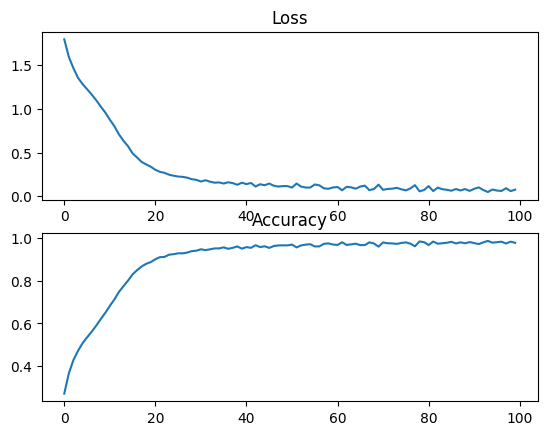

In [12]:
plt.subplot(2, 1, 1)
plt.plot(Loss)
plt.title('Loss')
plt.subplot(2, 1, 2)
plt.plot(Accuracy)
plt.title('Accuracy')
#plt.show()

In [13]:
# 保存模型
torch.save(model.state_dict(), 'model.pth')